# Azure AI Agent service - Code interpreter

<img src="agent.jpg" width=800>
<img src="foundry.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [38]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.projects.models import CodeInterpreterTool, FilePurpose
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image

In [2]:
load_dotenv("azure.env")

True

In [3]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [4]:
IMAGES_DIR = "images"

os.makedirs(IMAGES_DIR, exist_ok=True)

In [5]:
HOME_DIR = os.getcwd()

## Project

In [6]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.getenv("PROJECT_CONNECTION_STRING"),
)

## Examples

In [7]:
DOCUMENTS_DIR = "data"

os.makedirs(DOCUMENTS_DIR, exist_ok=True)

output_file = os.path.join(DOCUMENTS_DIR, "titanic.csv")

In [8]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-04-29 21:22:37--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.001s  

2025-04-29 21:22:37 (64.0 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [9]:
model = "gpt-4o-mini"

In [10]:
file = project_client.agents.upload_file_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-CcM2qCNtvRUKj2XGYeg8uU


In [11]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.agents.create_agent(
    model=model,
    name="Agent with code interpreter",
    instructions="You are a helpful AI agent that can analyse input file for statistics",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

## Example

In [12]:
prompt = "Plot a correlation matrix using the blues theme"

In [13]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)

Created thread, thread ID: thread_Iio2MqY7t1uKzlNXtqla1we4
Created message, message ID: msg_wYvaXhFrSilkZIvXEsLbWIPO
Created run, run ID: run_X4VhMoe9b5hqCBxtm3il4DWl


In [14]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here is the correlation matrix visualized with a blues theme. Each cell contains a correlation coefficient between the pairs of variables, with values ranging from -1 to 1:

- Values closer to 1 indicate a strong positive correlation.
- Values closer to -1 indicate a strong negative correlation.
- Values near 0 indicate no correlation.

In the matrix, you can observe:
- A moderate positive correlation between `Survived` and `Fare` (0.26).
- A moderate negative correlation between `Pclass` and `Fare` (-0.55).
- Other correlations are relatively low, indicating weaker relationships.

If you have any further analysis or additional requests, let me know!
--------------------------------------------------------------------------------
The uploaded dataset contains 891 entries and 12 columns. Here are the relevant details:

- **Numerical Columns**: `PassengerId`, `Survived`, `Pclass`, `Age`, `SibSp`, `Parch`, and `Fare`
- **Categorical Columns**: `Name`, `Sex`, `Ticket`, `Cabin`, and `Embark

In [15]:
os.chdir(IMAGES_DIR)

images_list = []

for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-3pAWoUD3n587YhjVcKQiyY
Saved image file to: assistant-3pAWoUD3n587YhjVcKQiyY_image.png


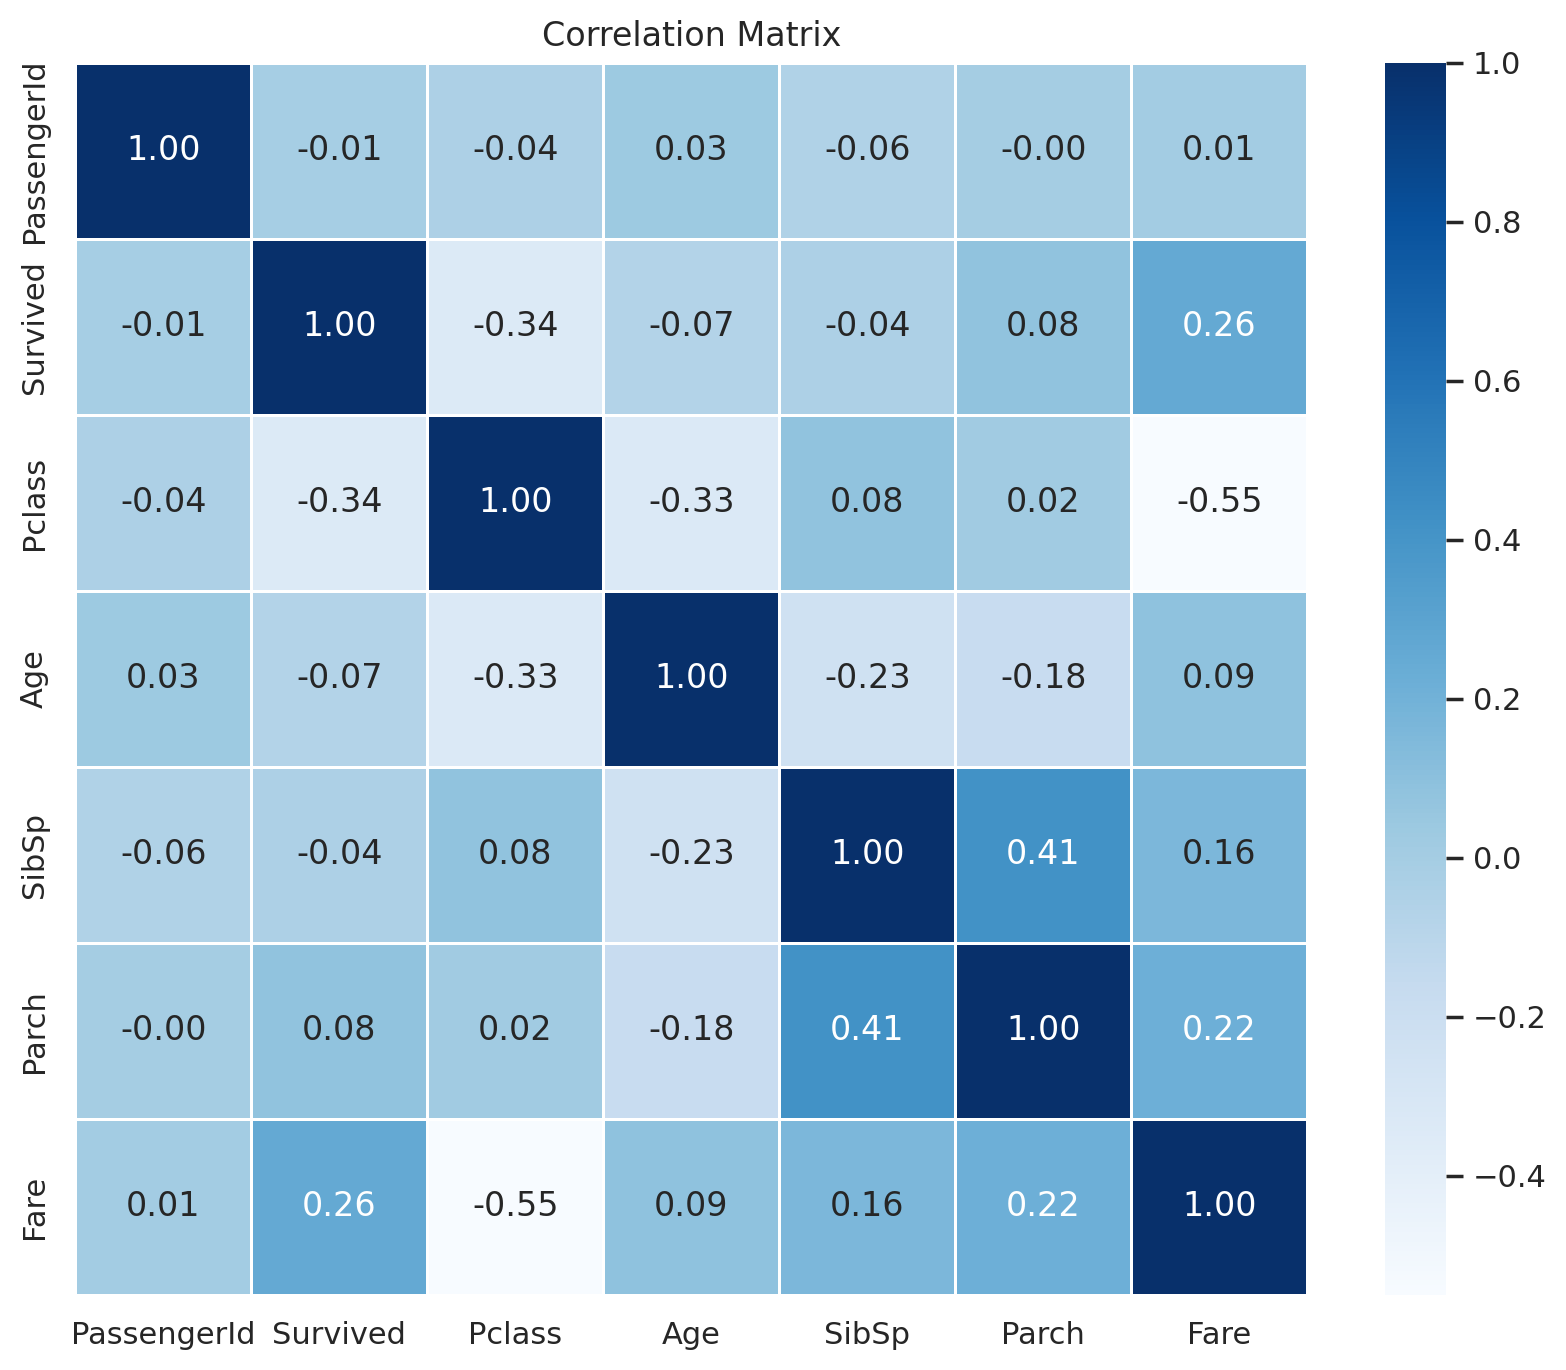

In [16]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [17]:
prompt = "Generate a survival count by Gender plot and the age distribution. Use some blues colors."

In [18]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_cBaOxs5Yoa73ywC1ulxS6UKC
Created message, message ID: msg_77yFmjcZDzmj2pIUZE7FyOTO
Created run, run ID: run_AcR0MOft3z8jpgdYvLHqAv5t
Messages: {'object': 'list', 'data': [{'id': 'msg_uVOrx08yrNjixoe8e6a4xapq', 'object': 'thread.message', 'created_at': 1745961800, 'assistant_id': 'asst_fMF1bcg7BZCeQrnDdD8Ka8Yy', 'thread_id': 'thread_cBaOxs5Yoa73ywC1ulxS6UKC', 'run_id': 'run_AcR0MOft3z8jpgdYvLHqAv5t', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-4gES1z5kjaTvf8u4roioUQ'}}, {'type': 'text', 'text': {'value': "Here are the generated plots:\n\n1. **Survival Count by Gender**: This bar plot displays the number of male and female passengers categorized by their survival status. The bars are colored in different shades of blue to represent survival (Yes or No).\n\n2. **Age Distribution of Passengers**: This histogram shows the distribution of passengers' ages, along with a Kernel Density Estimate (KDE) curve. The 

In [19]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here are the generated plots:

1. **Survival Count by Gender**: This bar plot displays the number of male and female passengers categorized by their survival status. The bars are colored in different shades of blue to represent survival (Yes or No).

2. **Age Distribution of Passengers**: This histogram shows the distribution of passengers' ages, along with a Kernel Density Estimate (KDE) curve. The blue color palette provides a visual representation of frequency across different age ranges.

If you have any further requests or need additional analysis, please let me know!
--------------------------------------------------------------------------------
The data includes information about Titanic passengers, specifically their survival status, gender, and age, among other details. 

Now, I'll generate two plots:
1. A bar plot showing the survival count by gender.
2. A histogram displaying the age distribution of the passengers.

Both plots will use shades of blue in their coloration. Le

In [20]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-4gES1z5kjaTvf8u4roioUQ
Saved image file to: assistant-4gES1z5kjaTvf8u4roioUQ_image.png


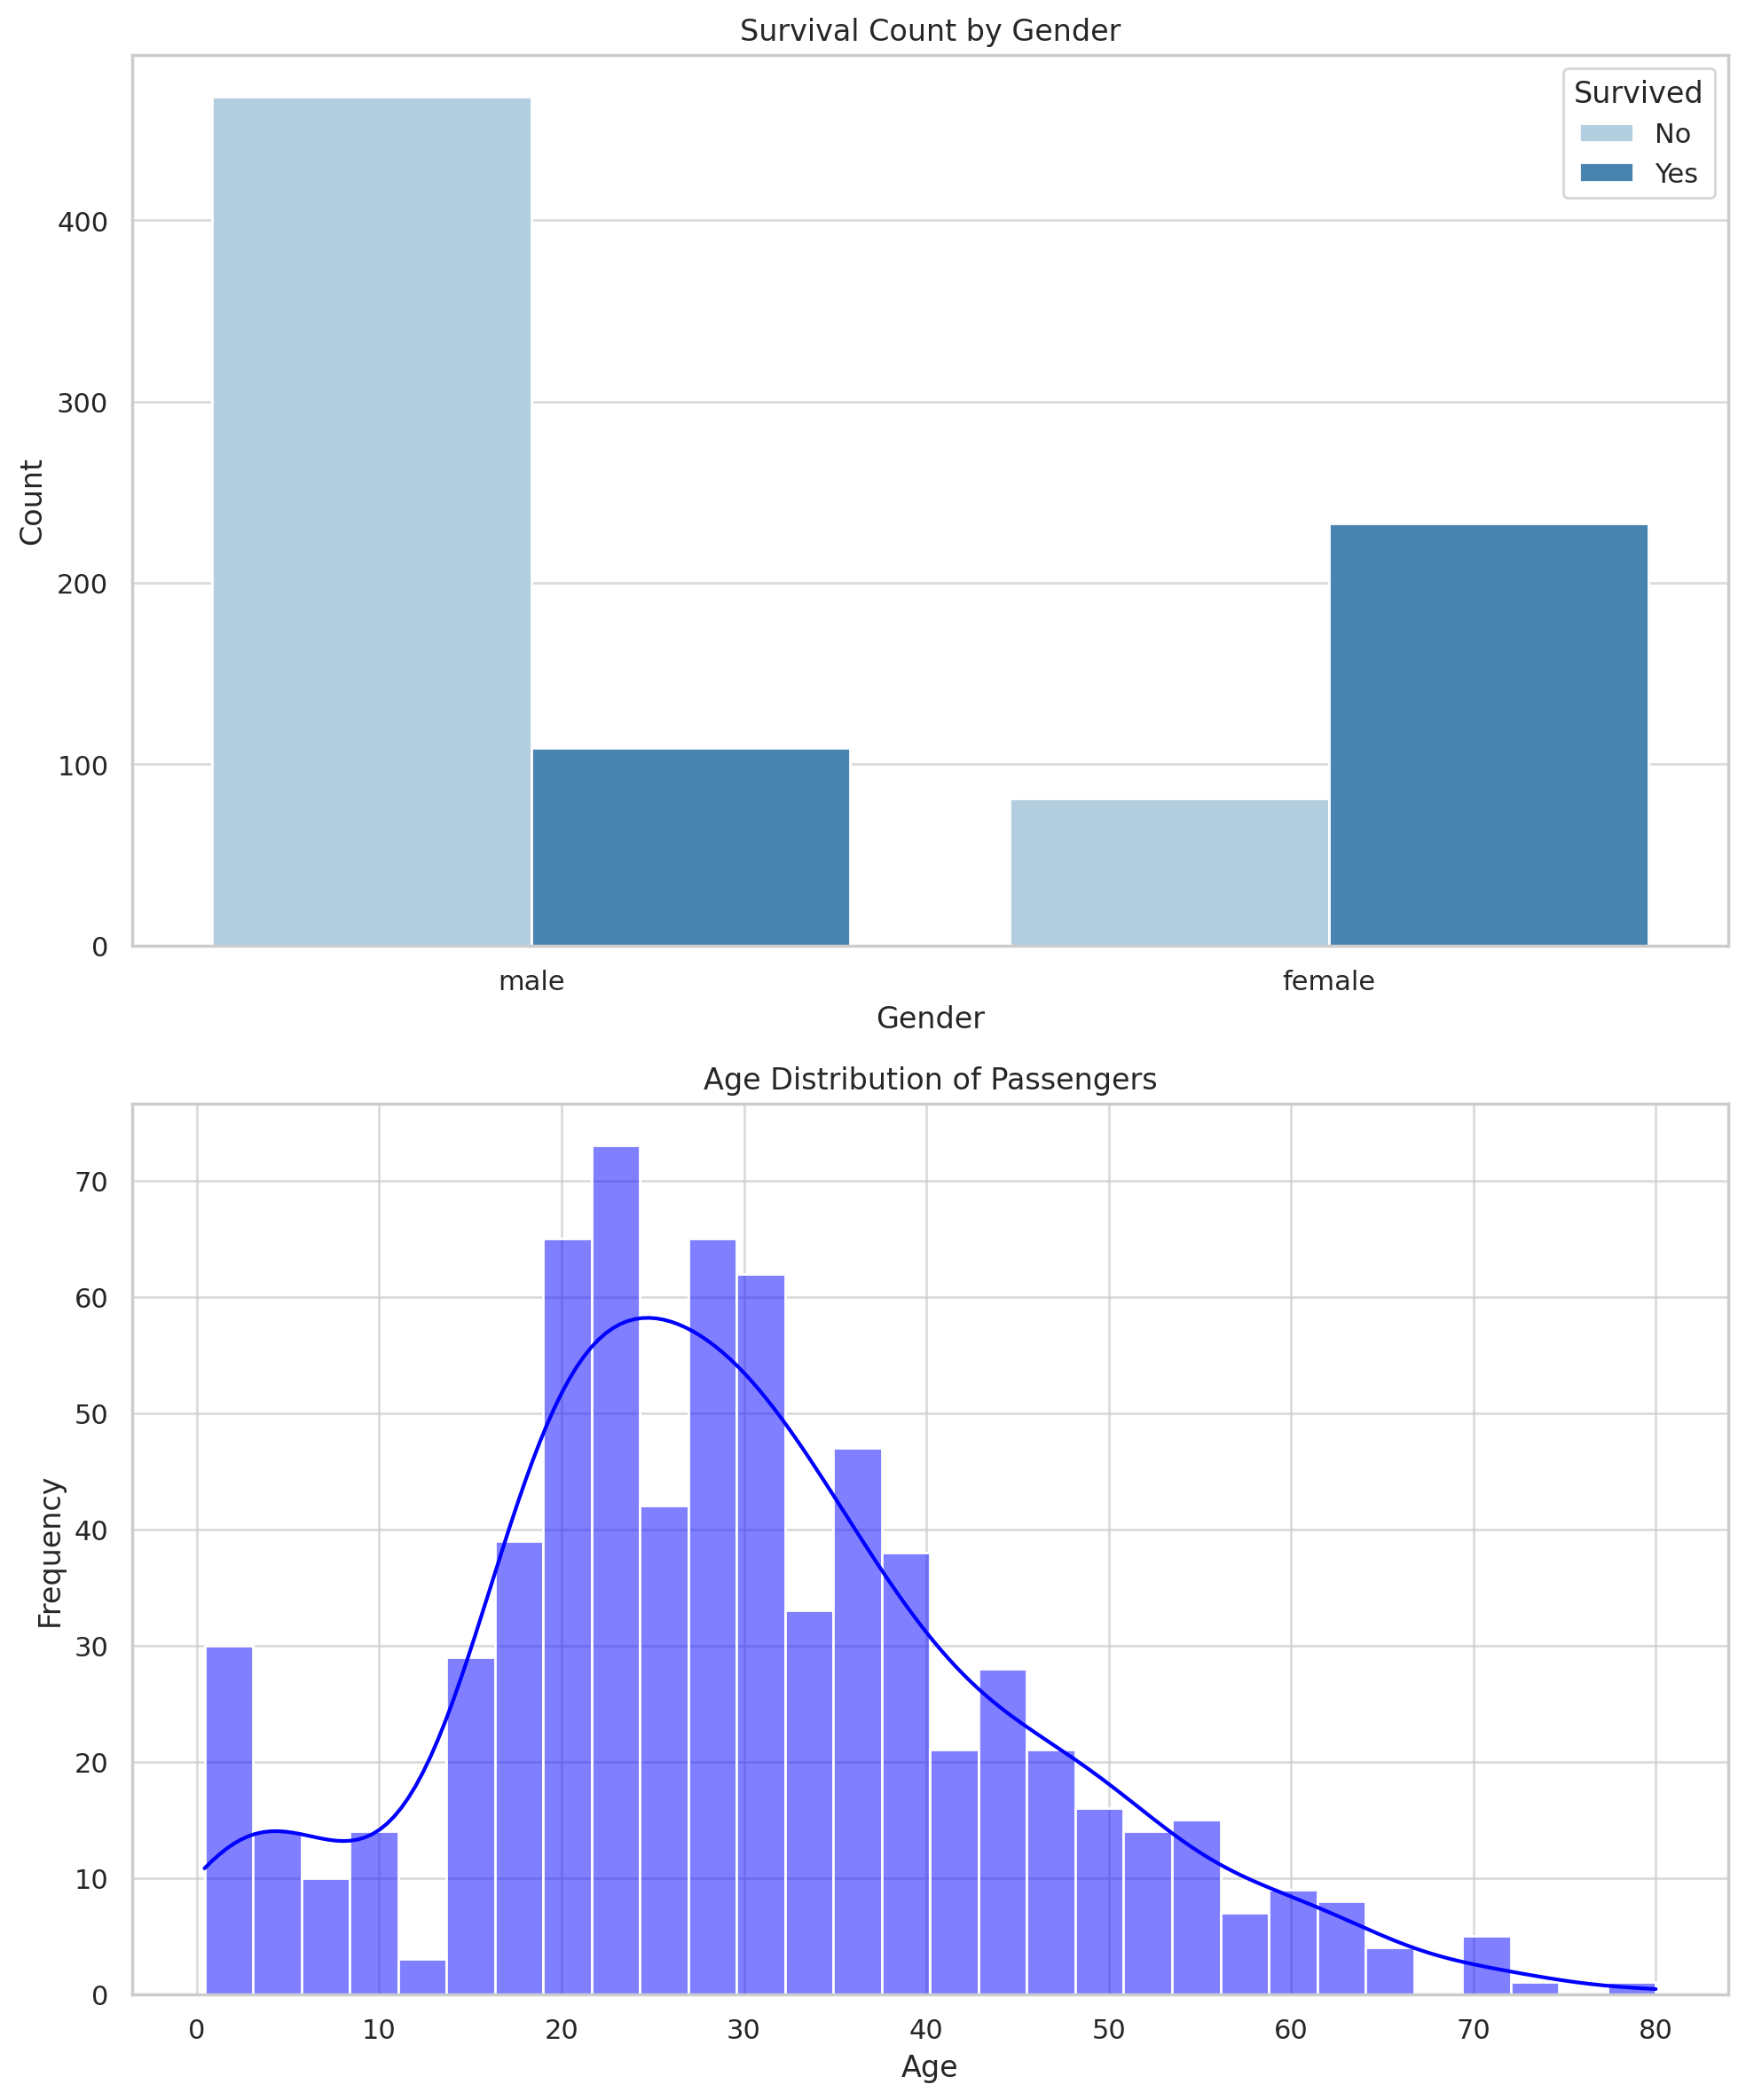

In [21]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [22]:
prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

In [23]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_lnWyAbKJCSfChGfUGu2q8tI2
Created message, message ID: msg_ngrNpgVa05i8jX6LzyYDdBWK
Created run, run ID: run_QR5AnVXLE9drNofjvVUqbdTq
Messages: {'object': 'list', 'data': [{'id': 'msg_lEzQVrnjhihW22JXLFwmvwSh', 'object': 'thread.message', 'created_at': 1745961827, 'assistant_id': 'asst_fMF1bcg7BZCeQrnDdD8Ka8Yy', 'thread_id': 'thread_lnWyAbKJCSfChGfUGu2q8tI2', 'run_id': 'run_QR5AnVXLE9drNofjvVUqbdTq', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-VPpEAaPt4RG4hQcfBArk9i'}}, {'type': 'text', 'text': {'value': 'The count plot above illustrates the bivariate analysis of survival (represented by the color intensity) by passenger class (Pclass):\n\n- **Passenger Class 1** tends to have a higher proportion of survivors compared to classes 2 and 3.\n- **Passenger Class 3** has the highest count of passengers, but also a larger number of non-survivors compared to survivors.\n\nThis visual representation helps us to u

In [24]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

The count plot above illustrates the bivariate analysis of survival (represented by the color intensity) by passenger class (Pclass):

- **Passenger Class 1** tends to have a higher proportion of survivors compared to classes 2 and 3.
- **Passenger Class 3** has the highest count of passengers, but also a larger number of non-survivors compared to survivors.

This visual representation helps us to understand how survival rates differed among the different classes of passengers on the Titanic. If you need further analysis or a different representation, feel free to ask!
--------------------------------------------------------------------------------
The dataset contains 891 entries, with the following relevant columns for our bivariate analysis:

- **Survived**: Indicates if the passenger survived (1) or did not survive (0).
- **Pclass**: Indicates the passenger's class (1, 2, or 3).

Next, I will create a bivariate analysis of survival and passenger class using a count plot, incorporat

In [25]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-VPpEAaPt4RG4hQcfBArk9i
Saved image file to: assistant-VPpEAaPt4RG4hQcfBArk9i_image.png


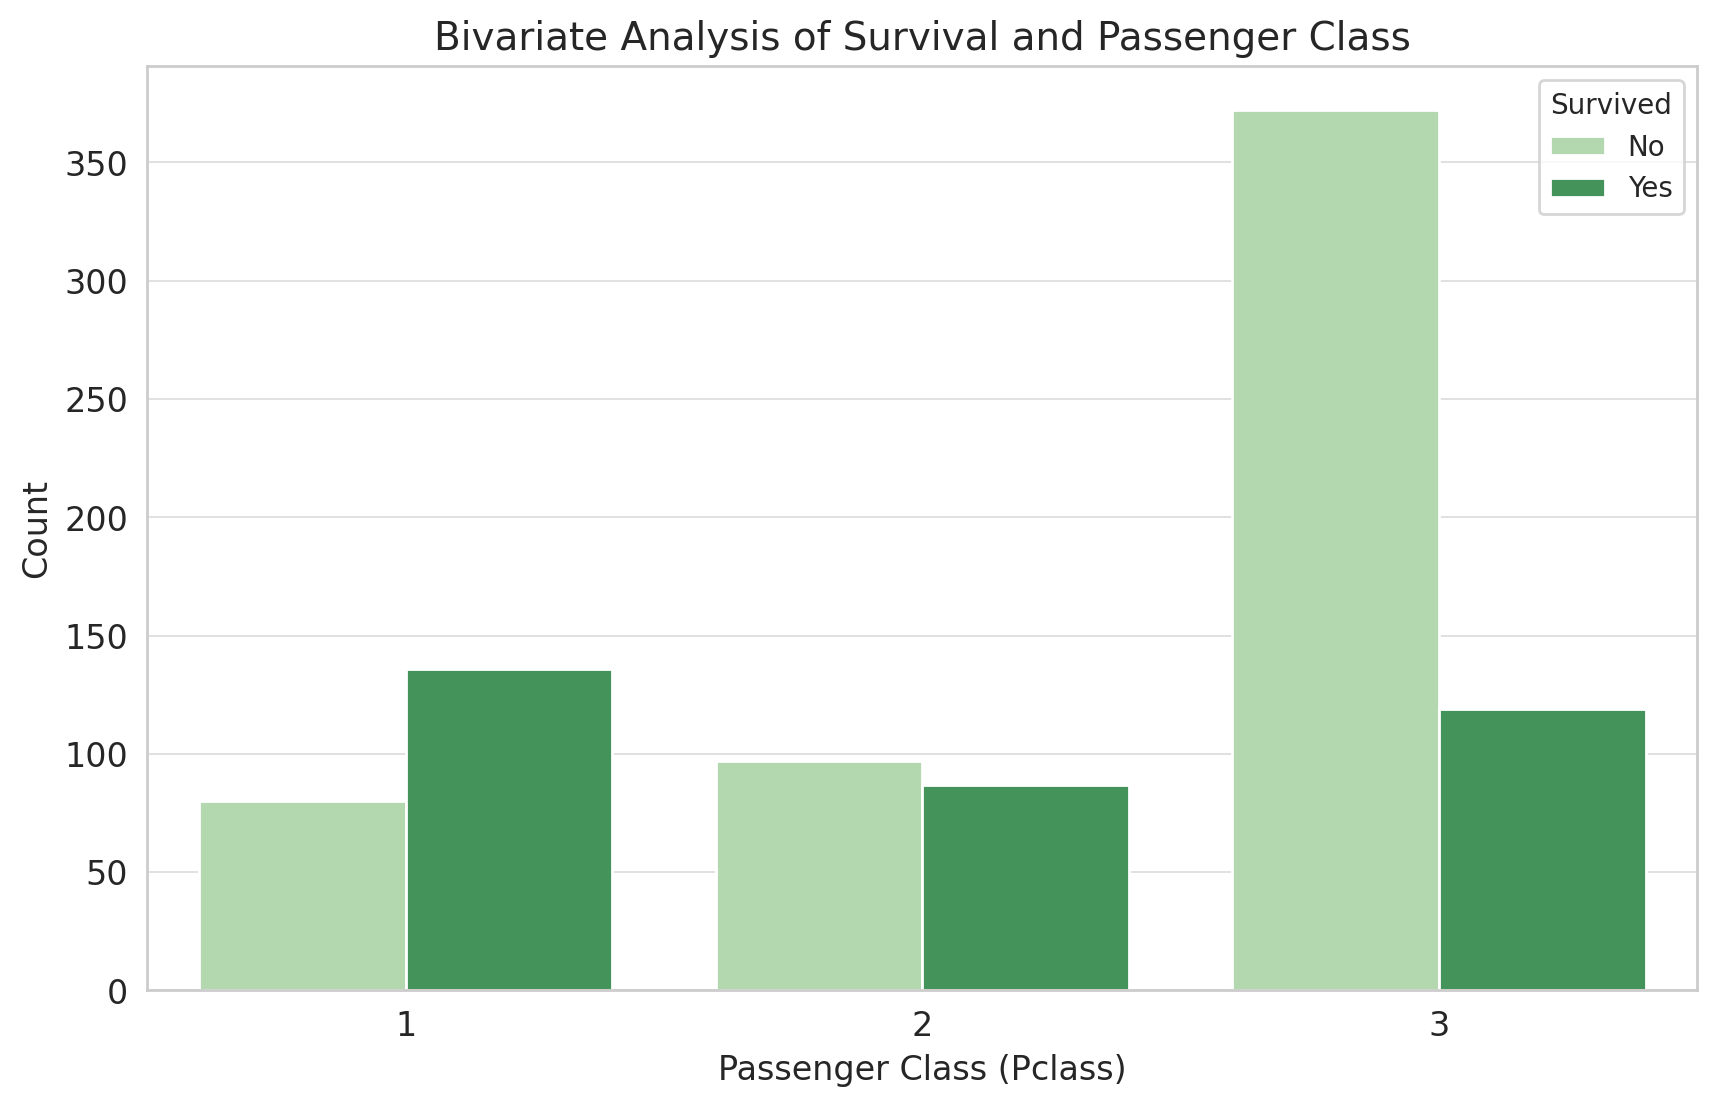

In [26]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [27]:
prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

In [28]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_EHWhN9sVXpWu0PhEfWTIbieW
Created message, message ID: msg_QifxUuYmIaFBUonPFHxKvl4B
Created run, run ID: run_cbYaBqiInlbGw7JqLIMcvy9x
Messages: {'object': 'list', 'data': [{'id': 'msg_hIAG4aZT3HSq6EiL9xJvQq28', 'object': 'thread.message', 'created_at': 1745961843, 'assistant_id': 'asst_fMF1bcg7BZCeQrnDdD8Ka8Yy', 'thread_id': 'thread_EHWhN9sVXpWu0PhEfWTIbieW', 'run_id': 'run_cbYaBqiInlbGw7JqLIMcvy9x', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-9iesnZ5DVvMbCRGP2yNPmY'}}, {'type': 'text', 'text': {'value': 'Here is the violin plot showing the distribution of Age by Passenger Class (Pclass) and Gender. The plot uses lime and cyan colors to differentiate between male and female passengers. Each violin shape represents the distribution of ages within each passenger class, allowing for comparisons between the sexes effectively. If you need any further analysis or modifications, feel free to ask!', 'annotations'

In [29]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here is the violin plot showing the distribution of Age by Passenger Class (Pclass) and Gender. The plot uses lime and cyan colors to differentiate between male and female passengers. Each violin shape represents the distribution of ages within each passenger class, allowing for comparisons between the sexes effectively. If you need any further analysis or modifications, feel free to ask!
--------------------------------------------------------------------------------
The dataset consists of 891 entries and 12 columns. The relevant columns for generating the violin plot are:

- `Pclass`: the class of the passenger (1, 2, or 3).
- `Age`: the age of the passenger.
- `Sex`: the gender of the passenger (male or female).

Next, I will handle any missing values in the `Age` column and proceed to create the violin plot using lime and cyan colors. Let's create the plot.
--------------------------------------------------------------------------------
To generate a violin plot of Pclass by Age a

In [30]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-9iesnZ5DVvMbCRGP2yNPmY
Saved image file to: assistant-9iesnZ5DVvMbCRGP2yNPmY_image.png


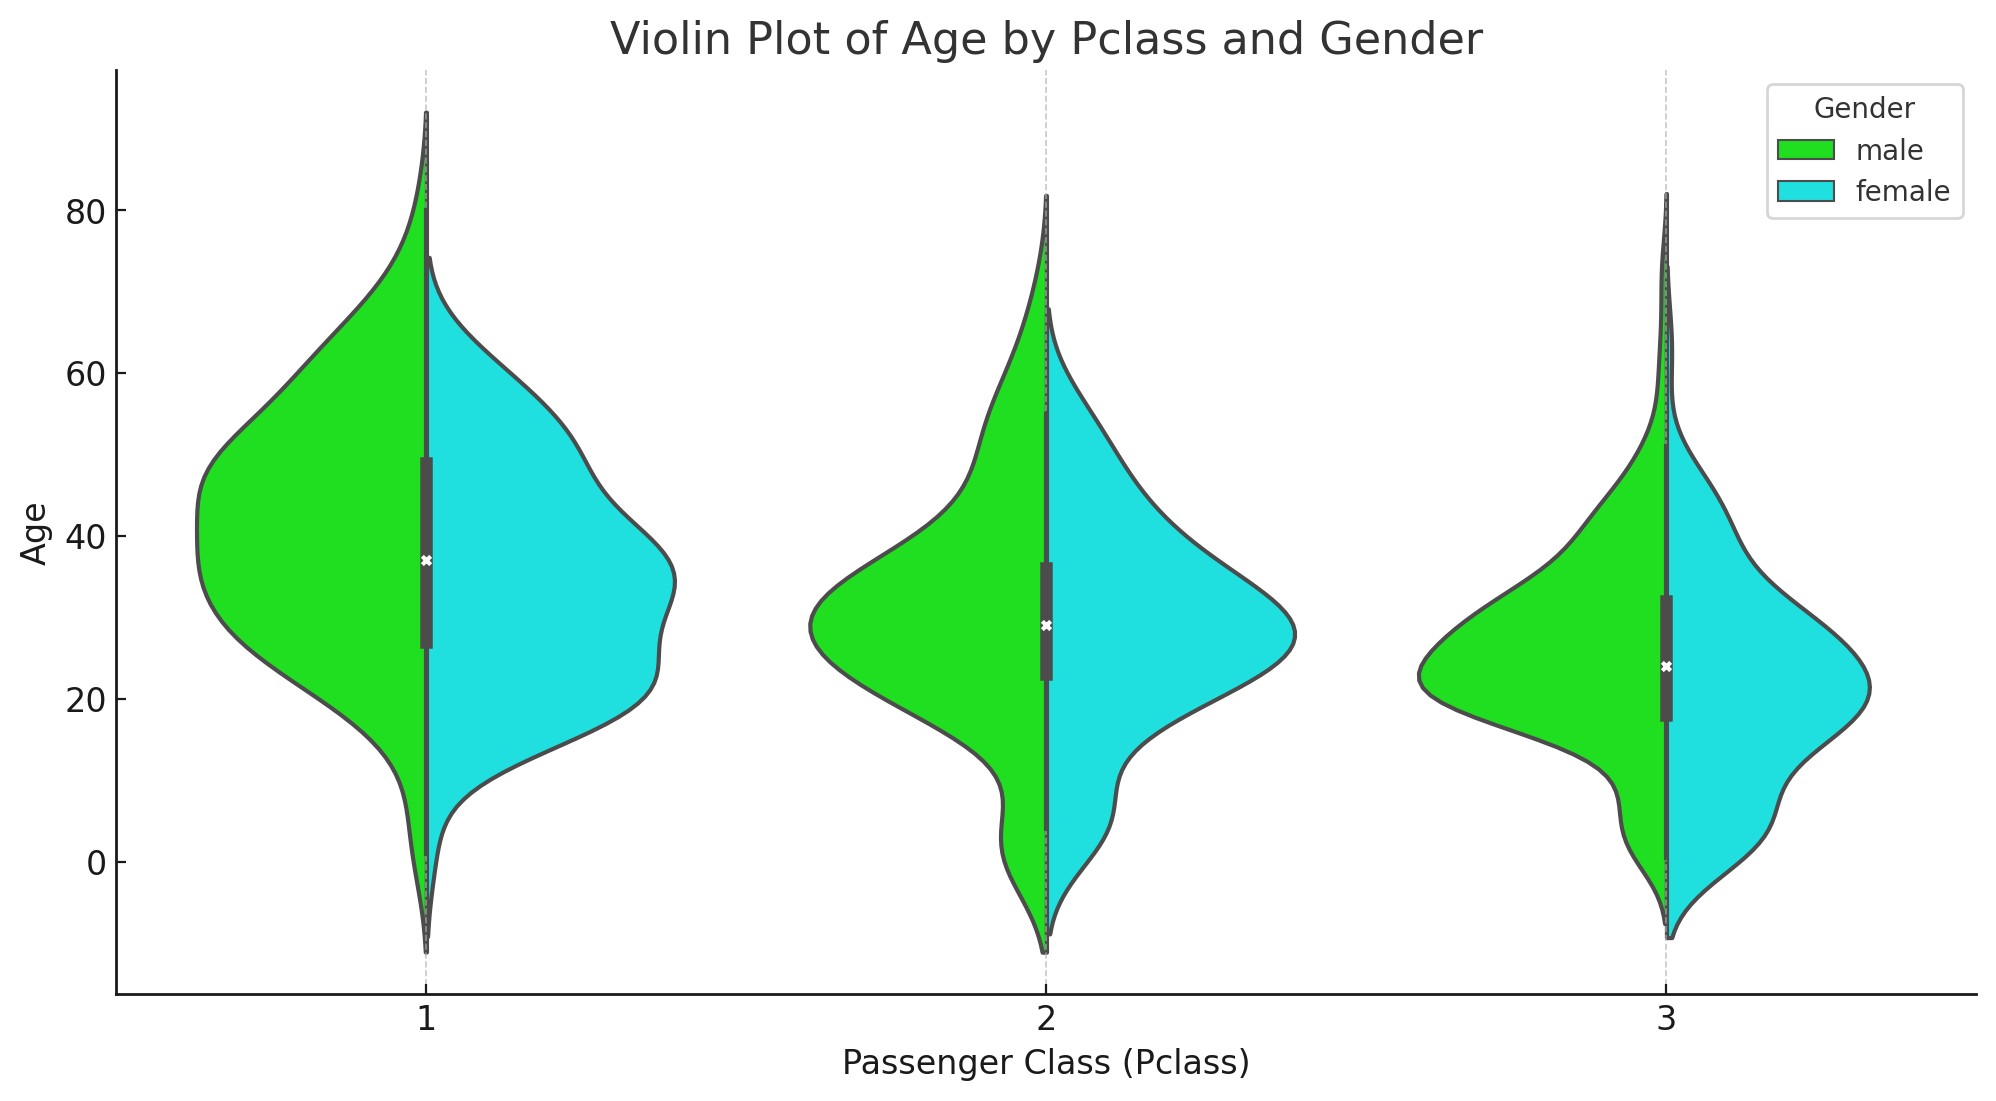

In [31]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## Example

In [32]:
prompt = "Generate the age distribution. Use lightblue color"

In [33]:
# create a thread
thread = project_client.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

# create a message
message = project_client.agents.create_message(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

# create and execute a run
run = project_client.agents.create_and_process_run(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# print the messages from the agent
messages = project_client.agents.list_messages(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_LEtLxPXpYpwkr0HnCCB7NFed
Created message, message ID: msg_dNaFqbs1fe0UZzmPYmiEk2O3
Created run, run ID: run_wDNT1PJDpbJAKiYbNDyYCPZ6
Messages: {'object': 'list', 'data': [{'id': 'msg_Oa1hANMdiXsIqU4mCbkACVNf', 'object': 'thread.message', 'created_at': 1745961861, 'assistant_id': 'asst_fMF1bcg7BZCeQrnDdD8Ka8Yy', 'thread_id': 'thread_LEtLxPXpYpwkr0HnCCB7NFed', 'run_id': 'run_wDNT1PJDpbJAKiYbNDyYCPZ6', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-2hjEzKq7pVL3XxH2hHxTBr'}}, {'type': 'text', 'text': {'value': 'Here is the age distribution of the passengers visualized in a histogram. The bars are colored in light blue, and they show the number of passengers across different age ranges.\n\nIf you need further analysis or have any other requests, feel free to ask!', 'annotations': []}}], 'attachments': [], 'metadata': {}}, {'id': 'msg_lEBB7JYK09bEN1hAHglq4DsF', 'object': 'thread.message', 'created_at': 1745961857

In [34]:
for message in messages['data']:
    for content in message['content']:
        if content['type'] == 'text':
            print(content['text']['value'])
            print('-' * 80)

Here is the age distribution of the passengers visualized in a histogram. The bars are colored in light blue, and they show the number of passengers across different age ranges.

If you need further analysis or have any other requests, feel free to ask!
--------------------------------------------------------------------------------
The "Age" column contains numerical values representing the ages of the passengers. Now, I will create a histogram to visualize the age distribution using a light blue color. Let's proceed with that.
--------------------------------------------------------------------------------
The file appears to be a CSV (Comma-Separated Values) file containing passenger data, which includes the following columns:

- PassengerId
- Survived
- Pclass
- Name
- Sex
- Age
- SibSp
- Parch
- Ticket
- Fare
- Cabin
- Embarked

To generate the age distribution, I'll extract the "Age" column, process it, and then create a histogram to visualize the age distribution using a light b

In [35]:
os.chdir(IMAGES_DIR)

images_list = []
for image_content in messages.image_contents:
    print(f"Image File ID: {image_content.image_file.file_id}")
    download_file_name = f"{image_content.image_file.file_id}_image.png"
    project_client.agents.save_file(file_id=image_content.image_file.file_id,
                                    file_name=download_file_name)
    print(f"Saved image file to: {download_file_name}")
    images_list.append(download_file_name)

os.chdir(HOME_DIR)

Image File ID: assistant-2hjEzKq7pVL3XxH2hHxTBr
Saved image file to: assistant-2hjEzKq7pVL3XxH2hHxTBr_image.png


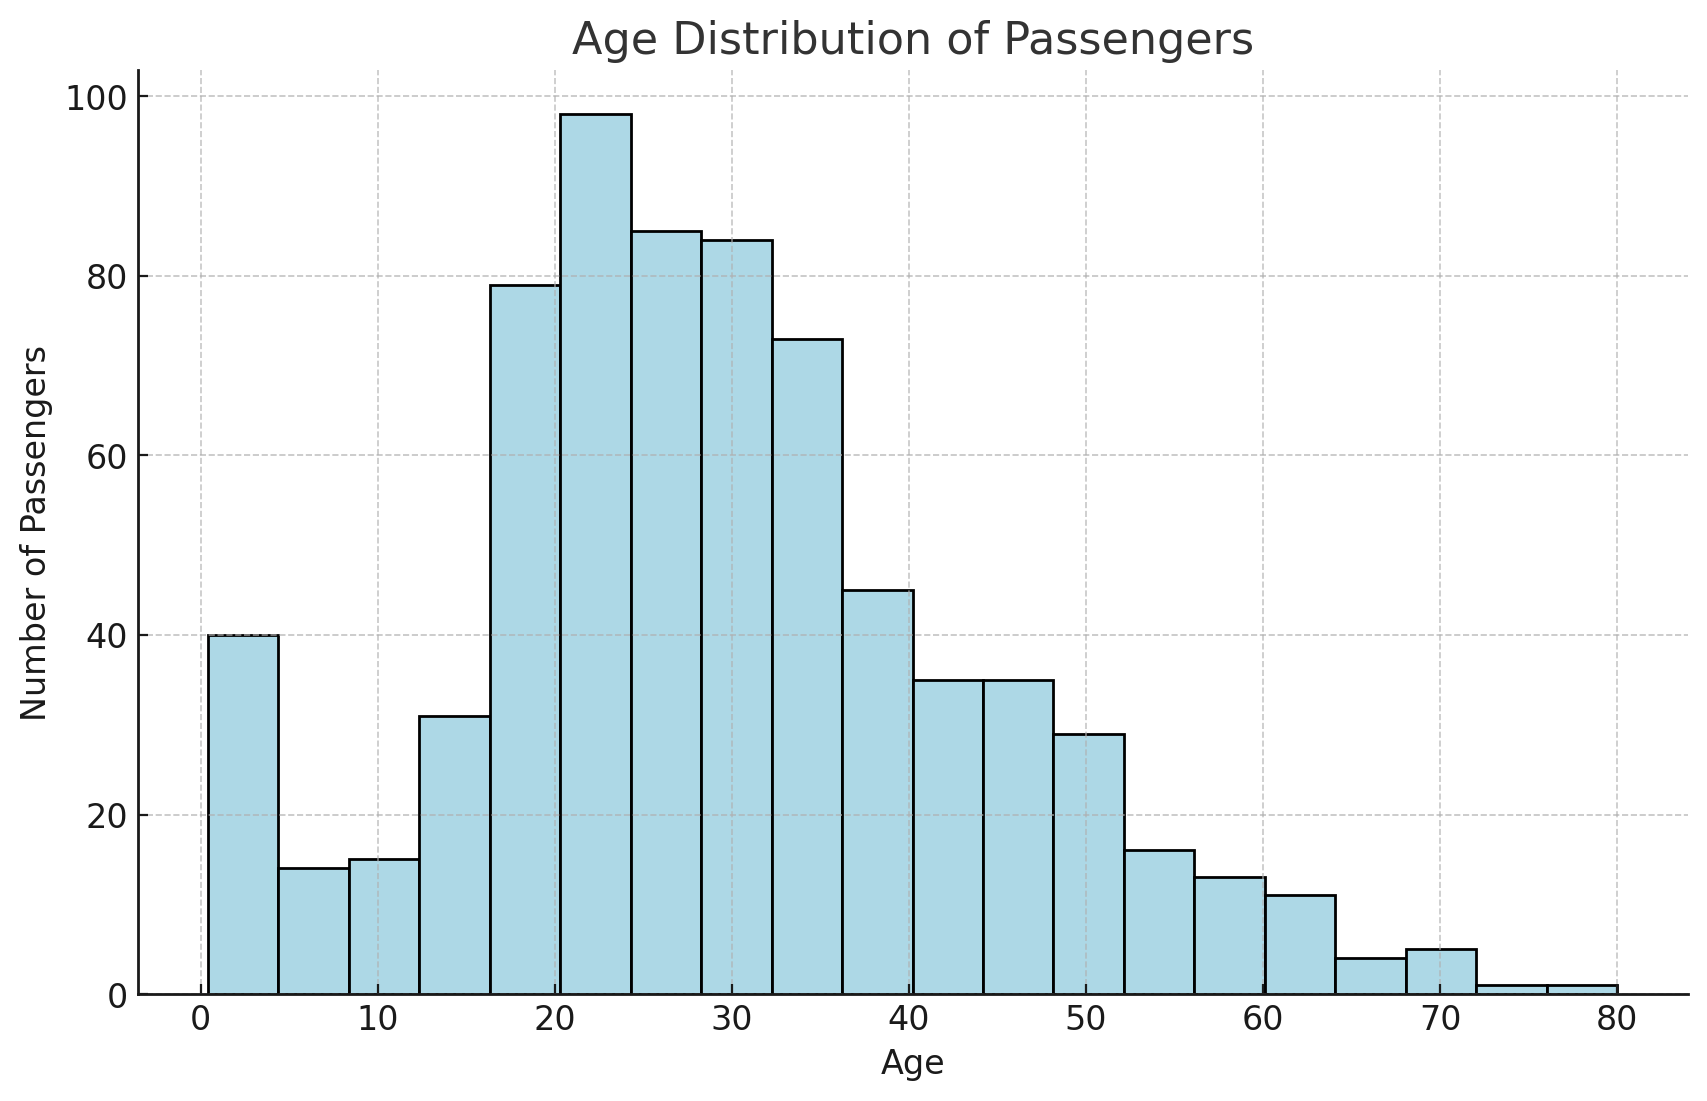

In [36]:
for i in range(len(images_list)):
    display(Image.open(os.path.join(IMAGES_DIR, images_list[i])))

## All images

In [46]:
def multiple_images(images_list, num_cols=4):
    """
    Display multiple images
    """
    num_rows = int(len(images_list) / num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_list):
            image = plt.imread(images_list[idx])
            ax.imshow(image)
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


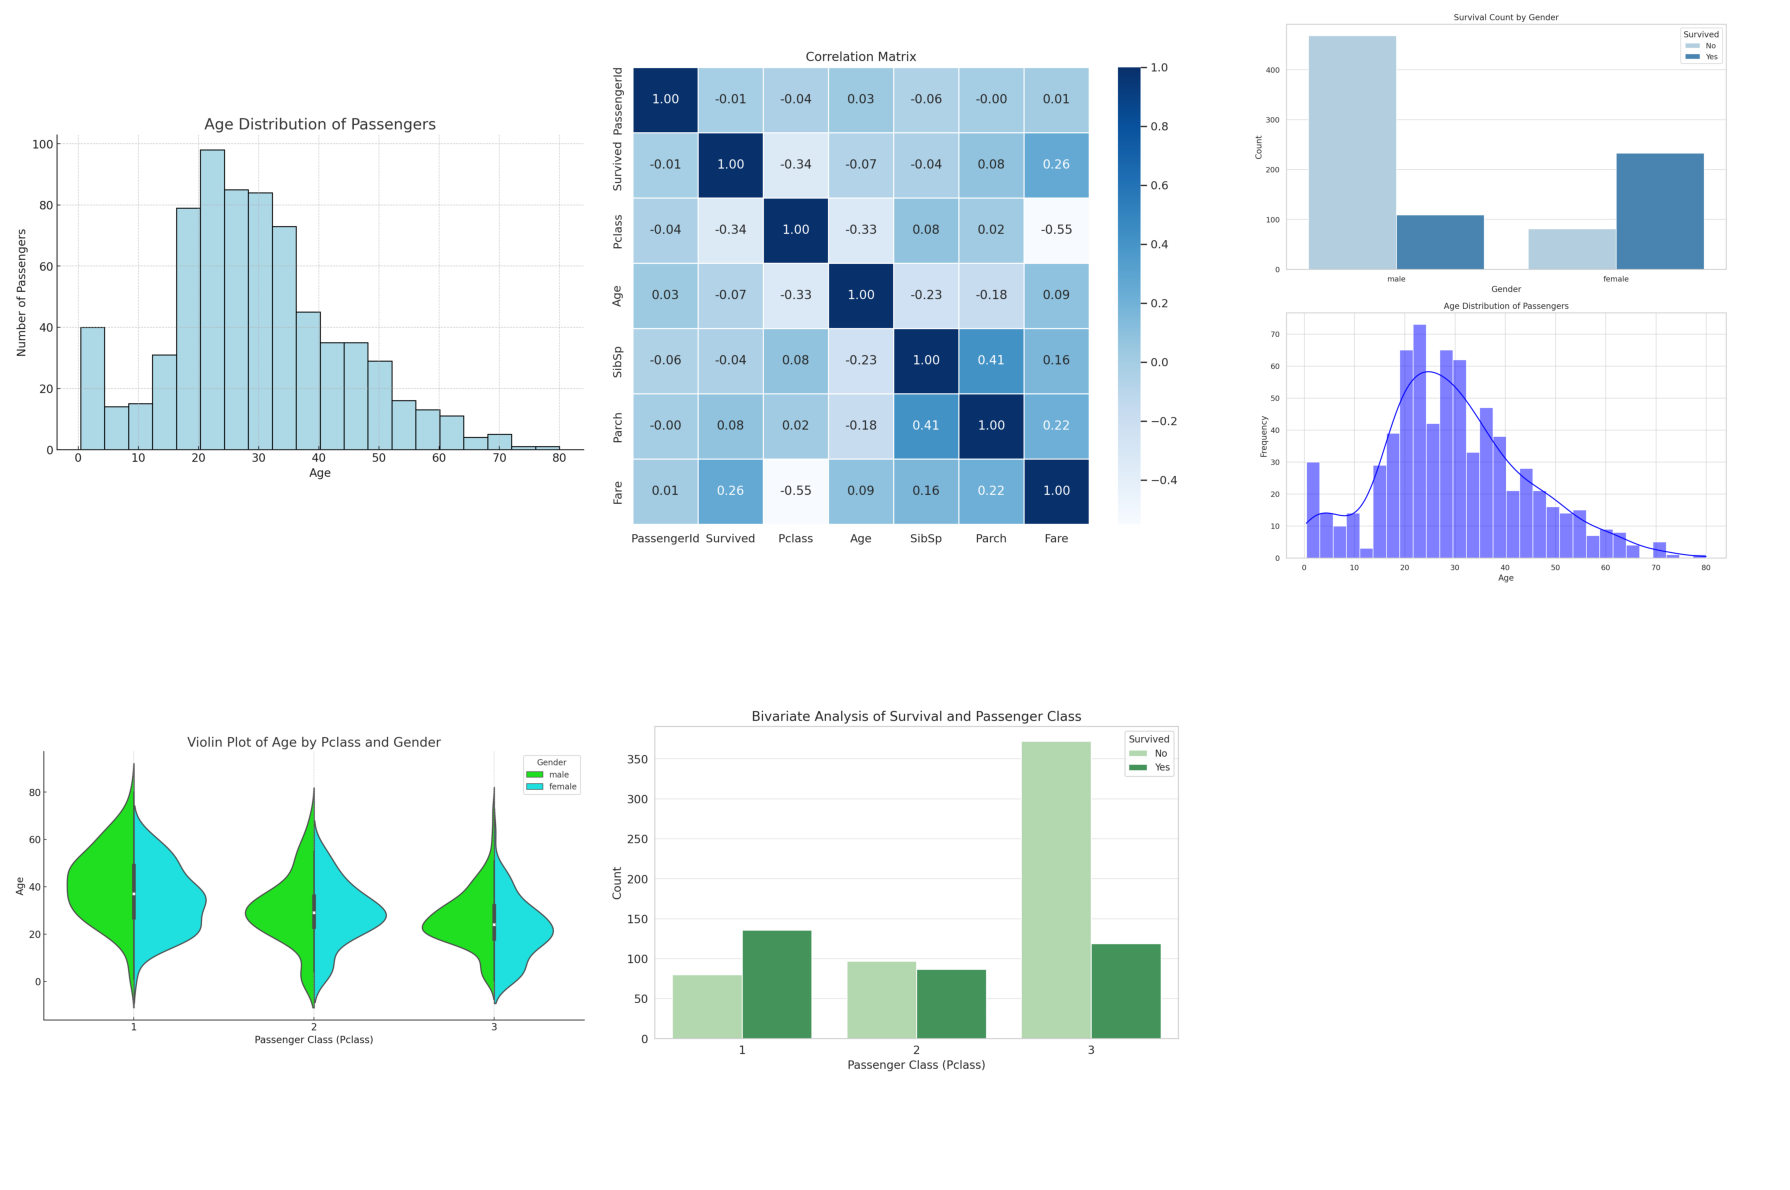

In [48]:
images_list = glob.glob(IMAGES_DIR +  '/*.png')

multiple_images(images_list, num_cols=3)

## Cleaning

In [49]:
for filename in os.listdir(IMAGES_DIR):
    if filename.endswith(".png"):
        image_file = os.path.join(IMAGES_DIR, filename)
        print(f"Deleting image file {image_file}")
        os.remove(image_file)

Deleting image file images/assistant-2hjEzKq7pVL3XxH2hHxTBr_image.png
Deleting image file images/assistant-3pAWoUD3n587YhjVcKQiyY_image.png
Deleting image file images/assistant-4gES1z5kjaTvf8u4roioUQ_image.png
Deleting image file images/assistant-9iesnZ5DVvMbCRGP2yNPmY_image.png
Deleting image file images/assistant-VPpEAaPt4RG4hQcfBArk9i_image.png


In [50]:
# delete the original file from the agent to free up space
print("Deleted file")
project_client.agents.delete_file(file.id)
print("Done")

Deleted file
Done


In [51]:
project_client.agents.delete_agent(agent.id)

{'id': 'asst_fMF1bcg7BZCeQrnDdD8Ka8Yy', 'object': 'assistant.deleted', 'deleted': True}